# Elo Score Calculation

In [31]:
import re
import os
from collections import defaultdict

In [32]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [98]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

## Getting a list of all the animals

- Because each cell does not contain the ID of all the animals that were competing, we will make a new column with both ID's

In [3]:
def get_all_animal_ids(animal_string):
    """
    Converts a string that contains the ID of animals, and only gets the IDs. 
    This usually removes extra characters that were added. (i.e. "1.1 v 2.2" to ("1.1", "2.2"))

    Args:
        animal_string(str): This is the first param.

    Returns:
        tuple: Of IDs of animals as strings
    """
    # Splitting by space so that we have a list of just the words
    all_words = animal_string.split()
    # Removing all words that are not numbers
    all_numbers = [num for num in all_words if re.match(r'^-?\d+(?:\.\d+)$', num)]
    return tuple(all_numbers)


## Elo Score Calculation

In [4]:
def calculate_elo_score(subject_elo_score, agent_elo_score, k_factor=20, score=1, number_of_decimals=None):
    """
    Calculates the Elo score of a given subject given it's original score, it's opponent, 
    the K-Factor, and whether or not it has won or not. 
    The calculation is based on: https://www.omnicalculator.com/sports/elo

    Args:
        subject_elo_score(float): The original Elo score for the subject
        agent_elo_score(float): The original Elo score for the agent
        k_factor(int): k-factor, or development coefficient. 
            - It usually takes values between 10 and 40, depending on player's strength 
        score(int): the actual outcome of the game. 
            - In chess, a win counts as 1 point, a draw is equal to 0.5, and a lose gives 0.
        number_of_decimals(int): Number of decimals to round to
        
    Returns:
        int: Updated Elo score of the subject
    """
    # Calculating the Elo score
    rating_difference = agent_elo_score - subject_elo_score
    expected_score = 1 / (1 + 10 ** (rating_difference / 400))
    new_elo_score = subject_elo_score + k_factor * (score - expected_score)
    # Rounding to `number_of_decimals`
    return round(new_elo_score, number_of_decimals)

# Calculate Elo score for Reward Competition

In [5]:
reward_competition_df = pd.read_excel("../../data/Pilot of Pilot - Reward Competition Video Scoring Assignments.xlsx", sheet_name="Master Master")

In [6]:
[col for col in reward_competition_df.columns if "Time" not in col]

['Date ',
 'Cage',
 'Box',
 'Match',
 'Trial 1 Winner',
 'Trial 2 Winner',
 'Trial 3 Winner',
 'Trial 4 Winner',
 'Trial 5 Winner',
 'Trial 6 Winner',
 'Trial 7 Winner',
 'Trial 8 Winner',
 'Trial 9 Winner',
 'Trial 10 Winner',
 'Trial 11 Winner',
 'Trial 12 Winner',
 'Trial 13 Winner',
 'Trial 14 Winner',
 'Trial 15 Winner',
 'Trial 16 Winner',
 'Trial 17 Winner',
 'Trial 18 Winner',
 'Trial 19 Winner',
 'Trial 20 Winner',
 'Mouse 1 Wins',
 'Mouse 2 Wins',
 'Ties ']

In [7]:
columns_to_keep = ['Date ',
 'Cage',
 'Box',
 'Match',
 'Trial 1 Winner',
 'Trial 2 Winner',
 'Trial 3 Winner',
 'Trial 4 Winner',
 'Trial 5 Winner',
 'Trial 6 Winner',
 'Trial 7 Winner',
 'Trial 8 Winner',
 'Trial 9 Winner',
 'Trial 10 Winner',
 'Trial 11 Winner',
 'Trial 12 Winner',
 'Trial 13 Winner',
 'Trial 14 Winner',
 'Trial 15 Winner',
 'Trial 16 Winner',
 'Trial 17 Winner',
 'Trial 18 Winner',
 'Trial 19 Winner',
 'Trial 20 Winner']

In [8]:
trimmed_reward_competition_df = reward_competition_df[columns_to_keep].copy()

In [9]:
trimmed_reward_competition_df.head()

,Date,Cage,Box,Match,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,Trial 6 Winner,...,Trial 11 Winner,Trial 12 Winner,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,Trial 20 Winner
0,2022-05-19,1,1,1.1 v 2.2,1.1,1.1,1.1,1.1,2.2,2.2,...,1.1,2.2,2.2,2.2,2.2,2.2,1.1,2.2,1.1,1.1
1,2022-05-19,1,2,2.3 v 1.4,1.4,1.4,2.3,2.3,1.4,1.4,...,2.3,2.3,2.3,2.3,1.4,1.4,1.4,1.4,2.3,2.3
2,2022-05-19,1,3,1.1 v 2.3,2.3,tie,2.3,1.1,1.1,2.3,...,2.3,2.3,1.1,2.3,2.3,2.3,2.3,2.3,2.3,NaN
3,2022-05-19,1,4,2.2 v 1.4,1.4,2.2,2.2,2.2,1.4,1.4,...,2.2,1.4,2.2,2.2,1.4,2.2,2.2,1.4,1.4,1.4
4,2022-05-19,1,2,2.2 v 2.3,2.2,2.3,2.3,2.3,2.2,2.3,...,2.3,tie,2.2,2.3,2.2,2.2,2.3,2.2,2.2,2.2


In [10]:
trimmed_reward_competition_df = trimmed_reward_competition_df.reset_index()

## Make a Column for each trial

In [11]:
trimmed_reward_competition_df["date_str"] = trimmed_reward_competition_df["Date "].apply(lambda x: str(x.date()))

In [12]:
trimmed_reward_competition_df.columns

Index(['index', 'Date ', 'Cage', 'Box', 'Match', 'Trial 1 Winner',
       'Trial 2 Winner', 'Trial 3 Winner', 'Trial 4 Winner', 'Trial 5 Winner',
       'Trial 6 Winner', 'Trial 7 Winner', 'Trial 8 Winner', 'Trial 9 Winner',
       'Trial 10 Winner', 'Trial 11 Winner', 'Trial 12 Winner',
       'Trial 13 Winner', 'Trial 14 Winner', 'Trial 15 Winner',
       'Trial 16 Winner', 'Trial 17 Winner', 'Trial 18 Winner',
       'Trial 19 Winner', 'Trial 20 Winner', 'date_str'],
      dtype='object')

In [13]:
trimmed_reward_competition_df

,index,Date,Cage,Box,Match,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,...,Trial 12 Winner,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,Trial 20 Winner,date_str
0,0,2022-05-19,1,1,1.1 v 2.2,1.1,1.1,1.1,1.1,2.2,...,2.2,2.2,2.2,2.2,2.2,1.1,2.2,1.1,1.1,2022-05-19
1,1,2022-05-19,1,2,2.3 v 1.4,1.4,1.4,2.3,2.3,1.4,...,2.3,2.3,2.3,1.4,1.4,1.4,1.4,2.3,2.3,2022-05-19
2,2,2022-05-19,1,3,1.1 v 2.3,2.3,tie,2.3,1.1,1.1,...,2.3,1.1,2.3,2.3,2.3,2.3,2.3,2.3,NaN,2022-05-19
3,3,2022-05-19,1,4,2.2 v 1.4,1.4,2.2,2.2,2.2,1.4,...,1.4,2.2,2.2,1.4,2.2,2.2,1.4,1.4,1.4,2022-05-19
4,4,2022-05-19,1,2,2.2 v 2.3,2.2,2.3,2.3,2.3,2.2,...,tie,2.2,2.3,2.2,2.2,2.3,2.2,2.2,2.2,2022-05-19
5,5,2022-05-19,1,1,1.1 v 1.4,1.4,1.1,1.4,1.4,1.1,...,1.1,1.1,1.4,1.4,1.4,1.4,1.4,1.4,1.1,2022-05-19
6,6,2022-05-20,1,4,1.1 v 1.4,1.1,1.1,1.1,1.1,1.1,...,1.1,1.1,1.1,1.1,1.1,1.1,Tie,1.4,NO TRIAL,2022-05-20
7,7,2022-05-20,1,3,2.2 v 2.3,2.2,2.2,2.2,2.2,tie,...,2.2,2.2,2.2,2.3,2.3,2.3,2.2,2.3,NaN,2022-05-20
8,8,2022-05-20,1,2,1.1 v 2.3,1.1,tie,2.3,1.1,1.1,...,tie,1.1,2.3,2.3,1.1,1.1,1.1,1.1,1.1,2022-05-20
9,9,2022-05-20,1,1,2.2 v 1.4,2.2,1.4,1.4,1.4,1.2,...,1.4,1.4,1.4,2.2,2.2,2.2,2.2,2.2,NaN,2022-05-20


In [14]:
melted_reward_competition_df = trimmed_reward_competition_df.melt(id_vars=["index", "Date ", "date_str", "Cage", "Box", "Match"], 
        var_name="Trial", 
        value_name="winner")

In [15]:
melted_reward_competition_df.head()

,index,Date,date_str,Cage,Box,Match,Trial,winner
0,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 1 Winner,1.1
1,1,2022-05-19,2022-05-19,1,2,2.3 v 1.4,Trial 1 Winner,1.4
2,2,2022-05-19,2022-05-19,1,3,1.1 v 2.3,Trial 1 Winner,2.3
3,3,2022-05-19,2022-05-19,1,4,2.2 v 1.4,Trial 1 Winner,1.4
4,4,2022-05-19,2022-05-19,1,2,2.2 v 2.3,Trial 1 Winner,2.2


In [16]:
melted_reward_competition_df["Trial Number"] = melted_reward_competition_df["Trial"].apply(lambda x: int(re.search(r'\d+', x).group())
)

In [17]:

reordered_reward_competition_df = melted_reward_competition_df.sort_values(['index', 'Trial Number'], ascending=[True, True]).reset_index(drop=True)

In [18]:
reordered_reward_competition_df

,index,Date,date_str,Cage,Box,Match,Trial,winner,Trial Number
0,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 1 Winner,1.1,1
1,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 2 Winner,1.1,2
2,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 3 Winner,1.1,3
3,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 4 Winner,1.1,4
4,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 5 Winner,2.2,5
...,...,...,...,...,...,...,...,...,...
955,47,2022-05-20,2022-05-20,4,1,4.3 (3) v 4.4 (4),Trial 16 Winner,4.3 (3),16
956,47,2022-05-20,2022-05-20,4,1,4.3 (3) v 4.4 (4),Trial 17 Winner,4.4 (4),17
957,47,2022-05-20,2022-05-20,4,1,4.3 (3) v 4.4 (4),Trial 18 Winner,Tie,18
958,47,2022-05-20,2022-05-20,4,1,4.3 (3) v 4.4 (4),Trial 19 Winner,4.4 (4),19


In [19]:
reordered_reward_competition_df["winner_str"] = reordered_reward_competition_df["winner"].apply(lambda x: str(x).lower().strip())

In [20]:
reordered_reward_competition_df["winner_str"].unique()

array(['1.1', '2.2', '1.4', '2.3', 'tie', 'nan', 'no trial', '1.2', '2.1',
       '1.3', '2.4', '4.1 (1)', '3.2 (2)', '4.2 (3)', '3.3 (4)', '4.1(1)',
       '3.1 (1)', '3.4 (2)', '4.3 (3)', '4.4 (4)'], dtype=object)

# Calculate Elo score for all cells

- Getting all the ID's of the animals

In [21]:
# Splitting by "v" and stripping all the spaces
reordered_reward_competition_df["all_animals"] = reordered_reward_competition_df["Match"].apply(lambda x: tuple([animal.strip() for animal in x.split("v")]))

In [22]:
reordered_reward_competition_df.head()

,index,Date,date_str,Cage,Box,Match,Trial,winner,Trial Number,winner_str,all_animals
0,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 1 Winner,1.1,1,1.1,"(1.1, 2.2)"
1,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 2 Winner,1.1,2,1.1,"(1.1, 2.2)"
2,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 3 Winner,1.1,3,1.1,"(1.1, 2.2)"
3,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 4 Winner,1.1,4,1.1,"(1.1, 2.2)"
4,0,2022-05-19,2022-05-19,1,1,1.1 v 2.2,Trial 5 Winner,2.2,5,2.2,"(1.1, 2.2)"


In [23]:
reordered_reward_competition_df.columns

Index(['index', 'Date ', 'date_str', 'Cage', 'Box', 'Match', 'Trial', 'winner',
       'Trial Number', 'winner_str', 'all_animals'],
      dtype='object')

## Get the Elo score for one fight

In [24]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
id_to_match_number = defaultdict(lambda:1)
for index, row in reordered_reward_competition_df.iterrows():
    # Checking if there is an Nan or not
    if row["winner_str"] == "nan":
        continue
    elif row["winner_str"] == "no trial":
        continue
    elif row["winner_str"] == "tie":
        winner_id = row["all_animals"][0]
        loser_id = row["all_animals"][1]
        winner_score = 0.5
        loser_score = 0.5 
    
    
    else:            
        winner_id = row["winner_str"]
        # Getting the ID of the loser subject
        loser_id = list(set(row["all_animals"]) - set([winner_id]))
        loser_id = loser_id[0]
        winner_score = 1
        loser_score = 0
        
        
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=winner_score, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=loser_score, number_of_decimals=1)

    date = row["date_str"]
    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[date + str(winner_id)]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["Cage"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = winner_score


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[date + str(loser_id)]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["Cage"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = loser_score

    id_to_match_number[date + str(winner_id)] += 1
    id_to_match_number[date + str(loser_id)] += 1
    

In [25]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {'1.1': 1076.7,
             '2.2': 1043.4,
             '1.4': 941.8,
             '2.3': 905.5,
             '1.2': 936.8,
             '2.1': 1069.2,
             '1.3': 978.7,
             '2.4': 1047.9,
             '4.1 (1)': 1069.7,
             '3.2 (2)': 973.7,
             '4.2 (3)': 980.7,
             '3.3 (4)': 963.6,
             '4.1(1)': 1012.3,
             '3.1 (1)': 1125.5,
             '3.4 (2)': 860.5,
             '4.3 (3)': 961.7,
             '4.4 (4)': 1052.3})

In [26]:
index_to_elo_score_and_meta_data[0]

{'date': '2022-05-19',
 'match_number': 1,
 'cage': 1,
 'subject_id': '1.1',
 'agent_id': '2.2',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1}

In [27]:
reward_competition_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [28]:
reward_competition_elo_score_df.head(n=25)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022-05-19,1,1,1.1,2.2,1000.0,1010.0,1.0
1,2022-05-19,1,1,2.2,1.1,1000.0,990.0,0.0
2,2022-05-19,2,1,1.1,2.2,1010.0,1019.4,1.0
3,2022-05-19,2,1,2.2,1.1,990.0,980.6,0.0
4,2022-05-19,3,1,1.1,2.2,1019.4,1028.3,1.0
5,2022-05-19,3,1,2.2,1.1,980.6,971.7,0.0
6,2022-05-19,4,1,1.1,2.2,1028.3,1036.7,1.0
7,2022-05-19,4,1,2.2,1.1,971.7,963.3,0.0
8,2022-05-19,5,1,2.2,1.1,963.3,975.4,1.0
9,2022-05-19,5,1,1.1,2.2,1036.7,1024.6,0.0


In [29]:
reward_competition_elo_score_df[75:125]

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
75,2022-05-19,18,1,2.3,1.4,1006.6,996.2,0.0
76,2022-05-19,19,1,2.3,1.4,996.2,1006.4,1.0
77,2022-05-19,19,1,1.4,2.3,1003.8,993.6,0.0
78,2022-05-19,20,1,2.3,1.4,1006.4,1016.0,1.0
79,2022-05-19,20,1,1.4,2.3,993.6,984.0,0.0
80,2022-05-19,21,1,2.3,1.1,1016.0,1025.7,1.0
81,2022-05-19,21,1,1.1,2.3,1005.9,996.2,0.0
82,2022-05-19,22,1,1.1,2.3,996.2,997.0,0.5
83,2022-05-19,22,1,2.3,1.1,1025.7,1024.9,0.5
84,2022-05-19,23,1,2.3,1.1,1024.9,1034.1,1.0


# Plotting the Elo Scores

In [84]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
cage_to_match_number = defaultdict(lambda:1)
for index, row in reordered_reward_competition_df.iterrows():
    # Checking if there is an Nan or not
    if row["winner_str"] == "nan":
        continue
    elif row["winner_str"] == "no trial":
        continue
    elif row["winner_str"] == "tie":
        winner_id = row["all_animals"][0]
        loser_id = row["all_animals"][1]
        winner_score = 0.5
        loser_score = 0.5 
    
    
    else:            
        winner_id = row["winner_str"]
        # Getting the ID of the loser subject
        loser_id = list(set(row["all_animals"]) - set([winner_id]))
        loser_id = loser_id[0]
        winner_score = 1
        loser_score = 0
        
        
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=winner_score, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=loser_score, number_of_decimals=1)

    date = row["date_str"]
    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = cage_to_match_number[date + str(row["Cage"])]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["Cage"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = winner_score


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = cage_to_match_number[date + str(row["Cage"])]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["Cage"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = loser_score

    cage_to_match_number[date + str(row["Cage"])] += 1
    

In [85]:
reward_competition_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

## Making the Dates into Numbers

In [86]:
reward_competition_elo_score_df["match_hour"] = reward_competition_elo_score_df["match_number"] / (reward_competition_elo_score_df["match_number"].max() + 1) * 24

In [87]:
reward_competition_elo_score_df["match_time"] = reward_competition_elo_score_df["match_hour"].apply(lambda x: str(timedelta(hours=x)).rsplit(':', 1)[0]) 

In [88]:
reward_competition_elo_score_df.head()

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,match_hour,match_time
0,2022-05-19,1,1,1.1,2.2,1000.0,1010.0,1.0,0.198347,0:11
1,2022-05-19,1,1,2.2,1.1,1000.0,990.0,0.0,0.198347,0:11
2,2022-05-19,2,1,1.1,2.2,1010.0,1019.4,1.0,0.396694,0:23
3,2022-05-19,2,1,2.2,1.1,990.0,980.6,0.0,0.396694,0:23
4,2022-05-19,3,1,1.1,2.2,1019.4,1028.3,1.0,0.595041,0:35


In [89]:
reward_competition_elo_score_df["date_with_hour"] = reward_competition_elo_score_df["date"].astype(str) + " " + reward_competition_elo_score_df["match_time"].astype(str)

In [90]:
# Given timestamp in string
time_str = '2021-7-24 11:30'
date_format_str = '%Y-%m-%d %H:%M'
# create datetime object from timestamp string
given_time = datetime.strptime(time_str, date_format_str)

In [91]:
print(given_time)

2021-07-24 11:30:00


In [92]:
reward_competition_elo_score_df["date_time"] = reward_competition_elo_score_df["date_with_hour"].apply(lambda x: datetime.strptime(x, date_format_str))

In [93]:
earliest_date = reward_competition_elo_score_df["date"].min()

In [94]:
latest_date = reward_competition_elo_score_df["date"].max()

In [95]:
earliest_date

'2022-05-19'

In [96]:
latest_date

'2022-05-20'

## Plotting the Scores

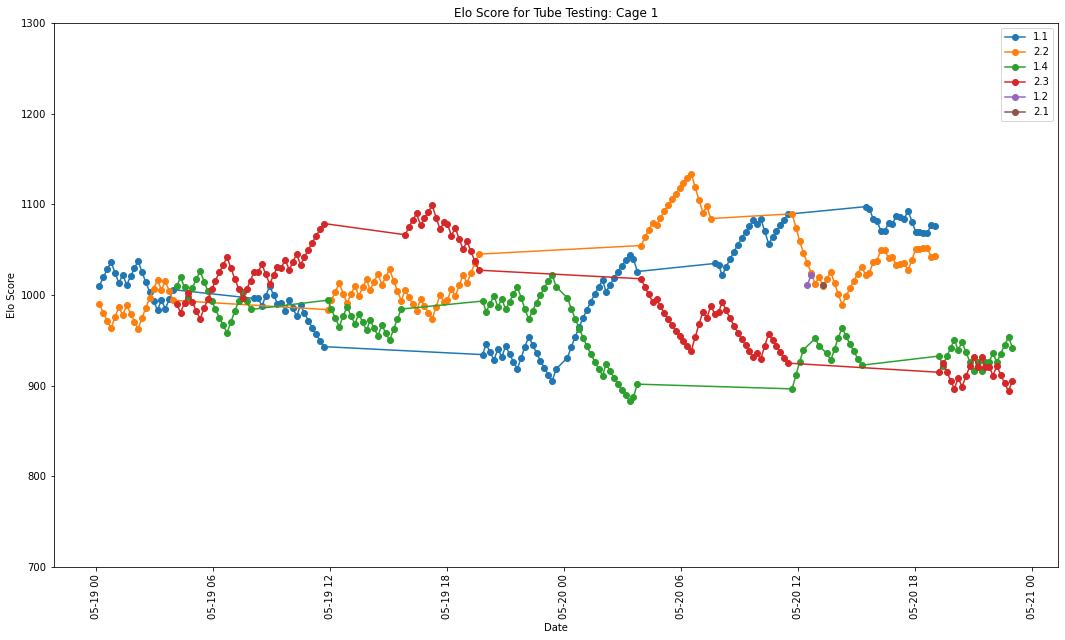

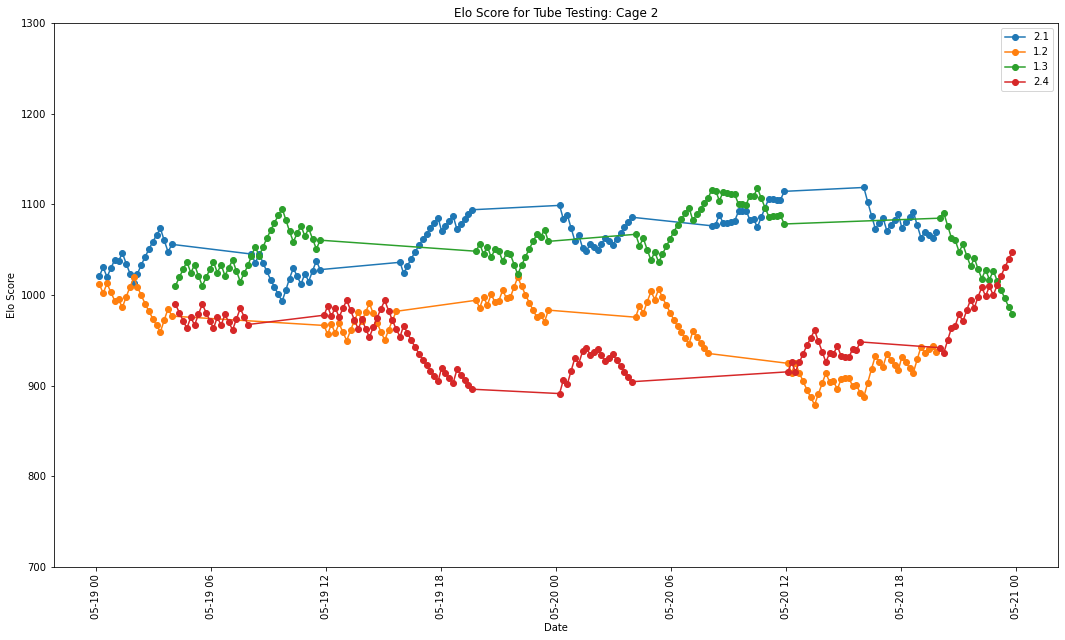

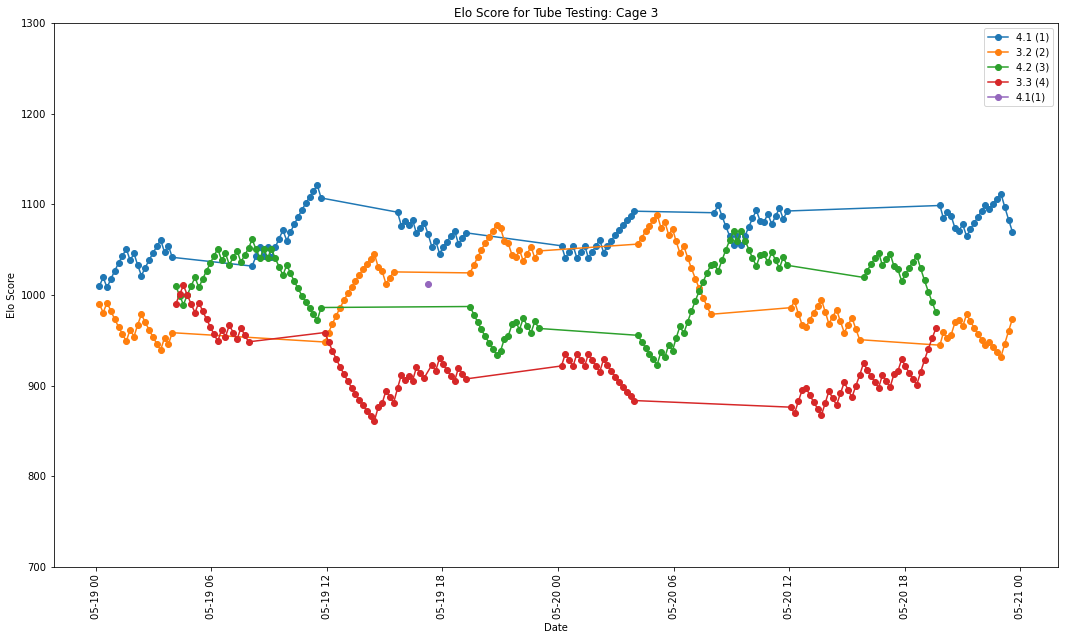

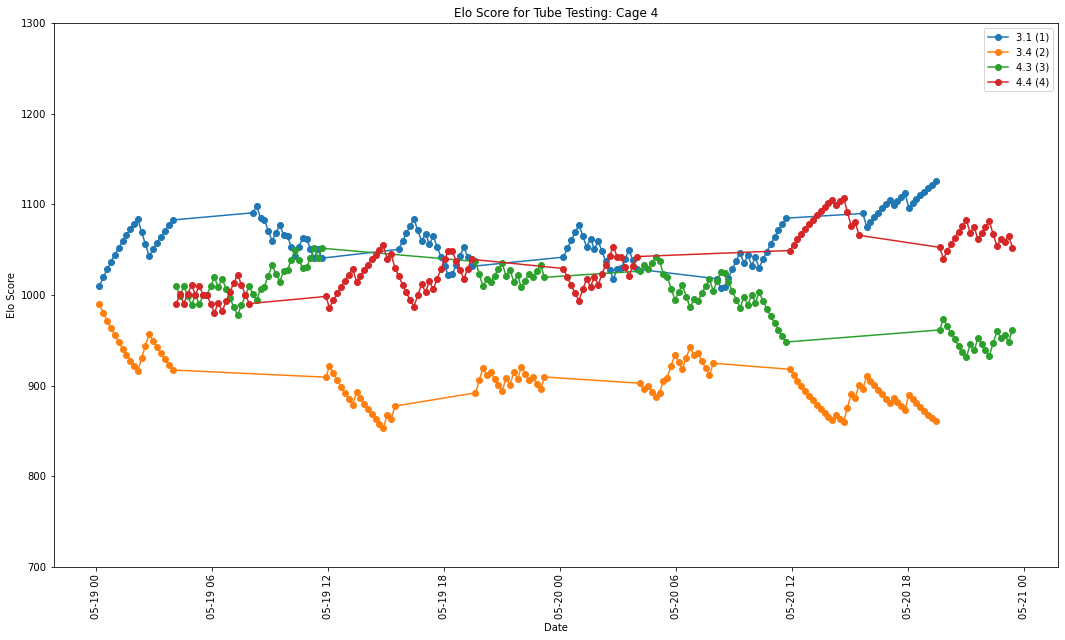

In [99]:
# Plotting for each cage
for cage in reward_competition_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = reward_competition_elo_score_df[reward_competition_elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject_id"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_time"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Tube Testing: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "reward_competition_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/reward_competition", file_name))


In [100]:
reward_competition_elo_score_df.to_csv("./proc/reward_competition_elo_score.csv")
# elo_score_df.to_excel("./proc/id_to_date_elo_score.xlsx")